## Basic Text Classification with Naive Bayes

In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on Lab 10 of Harvard's CS109 class. Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# setup pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# setup seaborn
sns.set_style('whitegrid')
sns.set_context('poster')

### Table of Contents
Rotten Tomatoes Dataset
    * Explore
* The Vector Space Model and a Search Engine
    * In Code
* Naive Bayes
    * Multinomial Naive Bayes and Other Likelihood Functions
    * Picking Hyperparameters for Naive Bayes and Text Maintenance
* Interpretation

### Rotten Tomatoes Dataset

In [3]:
critics = pd.read_csv('./datasets/critics.csv')
# let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [6]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of criticss: {:d}".format(n_critics))
print("Number of movies: {:d}".format(n_movies))

Number of reviews: 15561
Number of criticss: 623
Number of movies: 1921


([<matplotlib.axis.YTick at 0x2e825e01908>,
 <a list of 6 Text yticklabel objects>)

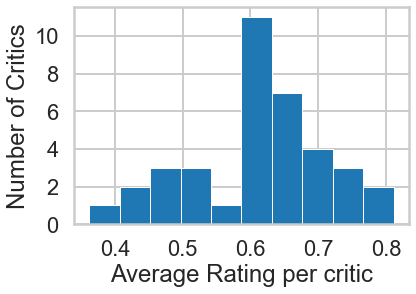

In [10]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count() # number of reviews by each critic
means = grp.fresh.mean() # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel('Average Rating per critic')
plt.ylabel('Number of Critics')
plt.yticks([0, 2, 4, 6, 8, 10])

E## xercise Set I

**Exercise:** Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?

The histogram above show that for critics that make more than 100 movie ratings, the average rating per critic is in between 0.4~0.8. Most of critics give average rating from 0.6 to 0.7, and few critics give average rating as low as 0.4, and few critics rated movie 0.55 or so averagely. The distribution looks bimodal, and could be related to some specific movies.

### The Vector Space Model and a Search Engine


All the diagrams here are snipped from Introduction to Information Retrieval by Manning et. al. which is a great resource on text processing. For additional information on text mining and natural language processing, see Foundations of Statistical Natural Language Processing by Manning and Schutze.

Also check out Python packages nltk, spaCy, pattern, and their associated resources. Also see word2vec.

### In Code

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

Original text is
Hop on pop
Hop off pop
Hop Hop hop


In [23]:
vectorizer = CountVectorizer(min_df=0)

# call 'fit' to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to convert back to a 
# 'normal' numpy array
x = x.toarray()

print("Transformed text vector is \n{}".format(x))

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]


In [24]:
# 'get_feature_names' tracks which is associated with each column of the transformed x
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Words for each feature:
['hop', 'off', 'on', 'pop']


In [26]:
def make_xy(critics, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc() # some version of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X,y
X, y = make_xy(critics)

### Naive Bayes